In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.utils import shuffle
from IPython.display import clear_output
from datetime import datetime
import pandas as pd
df=pd.read_csv('sample_images/fer2013.csv', sep=',',header=0)
df_train=df[df['Usage']=='Training']
df_test=df[df['Usage']!='Training']
del df

def str2image(x):
    return np.fromstring(x,sep=' ')

def convertFlat2Image(df):
    mat=df['pixels'].as_matrix()
    r_mat=np.array([str2image(xi).reshape(48,48,1) for xi in mat])
    return r_mat

X_train=convertFlat2Image(df_train)
X_test=convertFlat2Image(df_test)
y_train=df_train['emotion'].as_matrix()
y_test=df_test['emotion'].as_matrix()

In [2]:
def ImageAug(Xtrain,Ytrain,aug_size=500,critical_val=1.5):
    from keras.preprocessing.image import ImageDataGenerator
    import collections
    import numpy as np
    print("Input count :")
    print(collections.Counter(y_train))
    cat_dict=dict(collections.Counter(y_train))
    max_cat=max(cat_dict.values())
    Xtrain_aug = np.empty_like (Xtrain)
    Xtrain_aug[:] = Xtrain
    Ytrain_aug = np.empty_like (Ytrain)
    Ytrain_aug[:] = Ytrain
    for k in cat_dict:
        total_len=len(Xtrain_aug[Ytrain_aug==k])
        Xtrain_extra=np.empty((0,48,48,1))
        Ytrain_extra=np.empty(0)
        X_k=Xtrain[Ytrain==k]
        Y_k=Ytrain[Ytrain==k]
        datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
        datagen.fit(X_k)
        for X_batch, y_batch in datagen.flow(X_k,Y_k, batch_size=aug_size):
            Xtrain_extra=np.append(Xtrain_extra,X_batch,axis=0)
            Ytrain_extra=np.append(Ytrain_extra,y_batch,axis=0)
            total_len=total_len+aug_size
            if max_cat/total_len<critical_val:
                Xtrain_aug=np.append(Xtrain_aug,Xtrain_extra,axis=0)
                Ytrain_aug=np.append(Ytrain_aug,Ytrain_extra,axis=0)
                del Xtrain_extra
                del Ytrain_extra
                break
    print("Output count :")
    print(collections.Counter(Ytrain_aug))
    return Xtrain_aug,Ytrain_aug

In [13]:
def error_rate(p,t):
    return np.mean(p!=t)


def convpool(X,W,b):
    conv_out=tf.nn.conv2d(X,W,strides=[1,1,1,1],padding="SAME")
    conv_out=tf.nn.bias_add(conv_out,b)
    pool_out=tf.nn.max_pool(conv_out,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return pool_out

def convnopool(X,W,b):
    conv_out=tf.nn.conv2d(X,W,strides=[1,1,1,1],padding="SAME")
    conv_out=tf.nn.bias_add(conv_out,b)
#     pool_out=tf.nn.max_pool(conv_out,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return conv_out


def init_filter(shape,poolsz):
    w=np.random.randn(*shape)/np.sqrt(np.prod(shape[:-1])+shape[-1]*np.prod(shape[:-2]/np.prod(poolsz)))
    return w.astype(np.float32)

def init_dense(shape):
    w=np.random.randn(*shape)/np.sqrt(np.sum(shape))
    return w.astype(np.float32)

from functools import partial
he_init = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG") # he init method
scale=0.001
my_dense=partial(tf.layers.dense,activation=tf.nn.elu,
                 kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                 kernel_initializer=he_init)

def main():
    Xtrain_u=X_train[:28000,]/255
    Ytrain_u=y_train[:28000]
    Xtest=X_test[:7000,]/255
    Ytest=y_test[:7000]
    
    #augmenting the data
    Xtrain,Ytrain=ImageAug(Xtrain_u,Ytrain_u,aug_size=500,critical_val=1.5)
    
    n_epochs=100
    N=Xtrain.shape[0]
    batch_sz=200
    n_batches=N//batch_sz
    pool_sz=(2,2)

    learning_rate=0.00001
    tf.reset_default_graph()
    # cnn_pool layer 1
    W1_shape=(5,5,1,36)
    W1_init=init_filter(W1_shape,pool_sz)
    b1_init=np.zeros(W1_shape[-1],dtype=np.float32)

    # cnn_pool layer 2
    W2_shape=(5,5,36,81)
    W2_init=init_filter(W2_shape,pool_sz)
    b2_init=np.zeros(W2_shape[-1],dtype=np.float32)
    
#     pool_sz=(1,1)
#     # cnn_pool layer 3
#     W3_shape=(5,5,20,40)
#     W3_init=init_filter(W3_shape,pool_sz)
#     b3_init=np.zeros(W3_shape[-1],dtype=np.float32)

#     # cnn_pool layer 4
#     W4_shape=(3,3,40,80)
#     W4_init=init_filter(W4_shape,pool_sz)
#     b4_init=np.zeros(W4_shape[-1],dtype=np.float32)

    X=tf.placeholder(tf.float32,shape=(None,48,48,1),name="X")
    y=tf.placeholder(tf.int64,shape=(None),name="y")

    with tf.name_scope("cnn"):
        with tf.device("/gpu:0"):
            W1=tf.Variable(W1_init.astype(np.float32))
            b1=tf.Variable(b1_init.astype(np.float32))
            W2=tf.Variable(W2_init.astype(np.float32))
            b2=tf.Variable(b2_init.astype(np.float32)) 
            Z1=convpool(X,W1,b1)
            Z2=convpool(Z1,W2,b2)
#             W3=tf.Variable(W3_init.astype(np.float32))
#             b3=tf.Variable(b3_init.astype(np.float32))
#             Z3=convnopool(Z2,W3,b3)
            
#         with tf.device("/gpu:1"):    
#             W4=tf.Variable(W4_init.astype(np.float32))
#             b4=tf.Variable(b4_init.astype(np.float32))
#             Z4=convnopool(Z3,W4,b4)

    n_hidden1=2048
    n_hidden2=n_hidden1
    n_hidden3=n_hidden2//4
    n_outputs=7
    with tf.name_scope("dnn"):
        dropout_rate=0.3
        training=tf.placeholder_with_default(False,shape=(),name="training")
        with tf.device("/gpu:1"):
            Z_f=tf.contrib.layers.flatten(Z2)

            hidden1=my_dense(Z_f,n_hidden1,name="hidden1",kernel_initializer=he_init,
                             activation=tf.nn.elu)
            hidden1_drop=tf.layers.dropout(hidden1,dropout_rate,training=training)

            hidden2=my_dense(hidden1_drop,n_hidden2,name="hidden2",kernel_initializer=he_init,
                             activation=tf.nn.elu)
            hidden2_drop=tf.layers.dropout(hidden2,dropout_rate,training=training)
            
            hidden3=my_dense(hidden2_drop,n_hidden3,name="hidden3",kernel_initializer=he_init,
                             activation=tf.nn.elu)
            hidden3_drop=tf.layers.dropout(hidden3,dropout_rate,training=training)
            logits=my_dense(hidden3_drop,n_outputs, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                     kernel_initializer=he_init,name="outputs")

    with tf.name_scope("loss"):
        xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
        loss=tf.reduce_mean(xentropy,name="loss")

    with tf.name_scope("train"):
#         optimizer=tf.train.MomentumOptimizer(learning_rate=learning_rate,
#                                              momentum=0.95,use_nesterov=True)
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op=optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct=tf.nn.in_top_k(logits,y,3)
        accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))

    init=tf.global_variables_initializer()
    saver=tf.train.Saver()
    train_accuracy_save=[]
    test_accuracy_save=[]

    # calculate average accuracy
    beta=0.9
    def visualize_cnn(M,n=4):
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec

        plt.figure(figsize = (n,n))
        gs1 = gridspec.GridSpec(n, n)
        gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

        for i in range(n**2):
           # i = i + 1 # grid spec indexes from 0
            ax1 = plt.subplot(gs1[i])
            plt.axis('off')
            ax1.set_aspect('equal')
            ax1.imshow(M[0,:,:,i],cmap="gray")
        plt.show()
        
    def visualize_filter(W,n=4):
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec

        plt.figure(figsize = (n,n))
        gs1 = gridspec.GridSpec(n, n)
        gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

        for i in range(n**2):
           # i = i + 1 # grid spec indexes from 0
            ax1 = plt.subplot(gs1[i])
            plt.axis('off')
            ax1.set_aspect('equal')
            W_shape=W.shape
            ax1.imshow(np.reshape(W[:,:,0,i],(W_shape[0],W_shape[0])),cmap="gray")
        plt.show()


    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            Xtrain,Ytrain=shuffle(Xtrain,Ytrain)
            acc_train=1
            for iteration in range(N//batch_sz):
                X_batch,y_batch=(Xtrain[iteration*batch_sz:(iteration*batch_sz+batch_sz),:],
                                 Ytrain[iteration*batch_sz:(iteration*batch_sz+batch_sz)])
                sess.run(training_op,feed_dict={X:X_batch,y:y_batch,training:True}) # dropout=True
                acc_train=beta*acc_train+(1-beta)*accuracy.eval(feed_dict={X:X_batch,y:y_batch}) # dropout=True
            acc_test=accuracy.eval(feed_dict={X:Xtest,y:Ytest})
            clear_output()
            print(logits.eval(feed_dict={X:X_batch,y:y_batch})[0])
            print(epoch+1,"Train accuracy: ",acc_train," Test accuracy: ",acc_test,end="\r")
            visualize_cnn(Z2.eval(feed_dict={X:Xtest[:1],y:Ytest[:1]}),n=6)
            visualize_filter(W1.eval(),n=6)
            train_accuracy_save.append(acc_train)
            test_accuracy_save.append(acc_test)
        save_path=saver.save(sess,"model_checkpoints/fert_cnn.ckpt")

    x_number=range(1,len(test_accuracy_save)+1)
    plt.plot(x_number, train_accuracy_save, 'r--', x_number,test_accuracy_save)
    plt.show()

[-0.9941753  -0.9678011  -0.9999368  -0.99991703 -0.98393625 -0.999914
 -0.9956939 ]


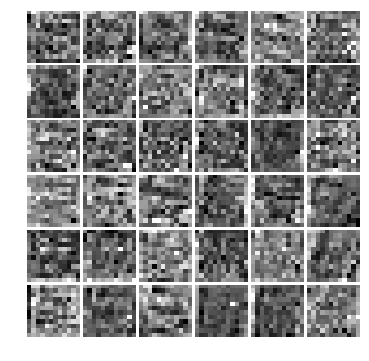

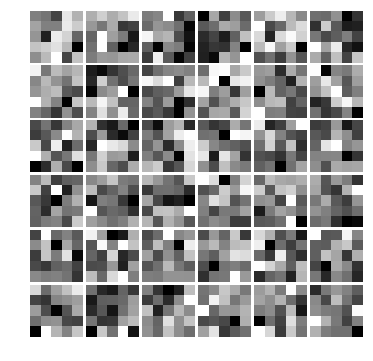

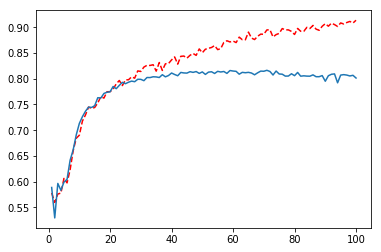

In [14]:
if __name__ == "__main__":
    main()